In [1]:
import pyarrow.dataset as ds
import pyarrow as pa


In [20]:

data = ds.dataset("mapd_probes", partitioning=ds.partitioning(pa.schema([("epoch", pa.int64()), ("stage", pa.string())]), flavor="filename"), format="parquet")
    

In [21]:
val_data = data.filter(ds.field("stage") == "val").to_table().to_pandas()

In [22]:
val_indices = val_data["sample_index"].unique()

In [23]:
val_indices

array([13110, 28725,  8234, ..., 68259, 23339, 77587])

In [24]:
train_data = data.filter(ds.field("stage") == "train").to_table().to_pandas()

In [25]:
# filter to remove all elements with sample index in val_indices
train_data = train_data[~train_data["sample_index"].isin(val_indices)]

In [26]:
train_data

,sample_index,loss,y_hat,y,epoch,stage
0,82067,1.604071,28,14,0,train
1,70846,0.050310,16,16,0,train
2,25776,0.119961,22,22,0,train
3,33908,0.071270,39,39,0,train
4,34480,0.115334,29,29,0,train
...,...,...,...,...,...,...
9023995,3412,0.665383,42,42,9,train
9023996,56704,0.005213,22,22,9,train
9023997,82660,1.242291,45,29,9,train
9023998,59855,0.912667,28,28,9,train


In [27]:
a = [0,1,2,3,4,5,6,7]

for num in a:
    print(num%2,num//2)

0 0
1 0
0 1
1 1
0 2
1 2
0 3
1 3


In [28]:
import dill as pickle

with open("probe_suite_ds.pkl", "rb") as f:
    probe_suite_dataset = pickle.load(f)

In [53]:
suite_indices = probe_suite_dataset.index_to_suite
# get unique values
suites = list(set(suite_indices.values()))

# make dict of suite to name of suite
suite_to_name = {}
for suite in suites:
    test = suite.split("_")

    # capitalize first word of each suite
    test = [word.capitalize() for word in test]
    # join words with space
    test = " ".join(test)
    suite_to_name[suite] = test

suite_to_name


{'train': 'Train',
 'atypical': 'Atypical',
 'random_outputs': 'Random Outputs',
 'typical': 'Typical',
 'random_inputs_outputs': 'Random Inputs Outputs'}

In [54]:
# get all typical indices
import random

for suite_attr, suite_name in suite_to_name.items():
    indices = [idx for idx, suite in suite_indices.items() if suite == suite_attr]
    random.shuffle(indices)
    train_indices = indices[:250]
    val_indices = indices[250:]
    val_data.loc[val_data["sample_index"].isin(train_indices), "suite"] = suite_name
    val_data.loc[val_data["sample_index"].isin(val_indices), "suite"] = suite_name + " [Val]"

In [65]:
train_data["suite"] = "Other"

In [74]:


# add predictions to val_data that is True if y == y_hat
val_data["prediction"] = val_data["y"] == val_data["y_hat"]
val_df = val_data.groupby(["epoch", "suite"]).agg({"prediction": "mean"})
val_df.reset_index(inplace=True)
val_df["prediction"] = val_df["prediction"] * 100

train_data["prediction"] = train_data["y"] == train_data["y_hat"]
train_df = train_data.groupby(["epoch", "suite"]).agg({"prediction": "mean"})
train_df.reset_index(inplace=True)
train_df["prediction"] = train_df["prediction"] * 100

# all suites
val_suites = val_df["suite"].unique()
train_suites = train_df["suite"].unique()
all_suites = sorted(val_suites) + sorted(train_suites)


In [75]:
all_suites

['Atypical',
 'Atypical [Val]',
 'Random Inputs Outputs',
 'Random Inputs Outputs [Val]',
 'Random Outputs',
 'Random Outputs [Val]',
 'Train',
 'Train [Val]',
 'Typical',
 'Typical [Val]',
 'Other']

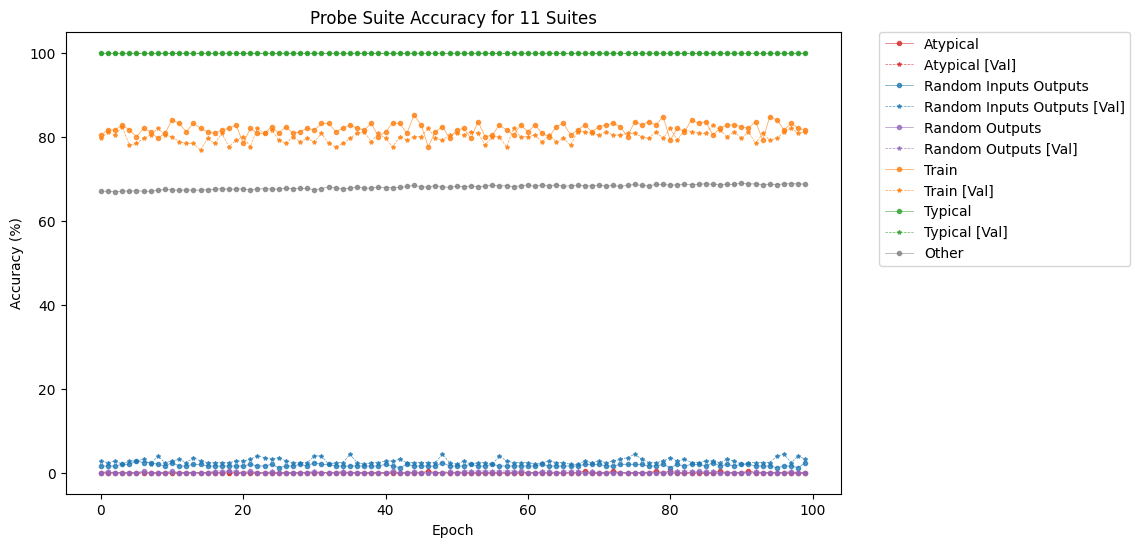

In [84]:
# plot

line_styles = ["solid", "dashed", "dashdot", "dotted"]

marker_list = ["o", "*"]

marker_colors = [
            "tab:red",
            "tab:blue",
            "tab:purple",
            "tab:orange",
            "tab:green",
            "tab:pink",
            "tab:olive",
            "tab:brown",
            "tab:cyan",
            "tab:gray",
        ]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.title(f"Probe Suite Accuracy for {len(all_suites)} Suites")
for i, suite in enumerate(all_suites):
    if "Other" in suite:
        plt.plot(
                train_df[train_df["suite"] == suite]["epoch"],
                train_df[train_df["suite"] == suite]["prediction"],
                label=suite,
                alpha=0.75,
                linewidth=0.5,
                linestyle=line_styles[0],
                marker=marker_list[0],
                markersize=3,
                color=marker_colors[-1],
            )
    else:
        plt.plot(
                val_df[val_df["suite"] == suite]["epoch"],
                val_df[val_df["suite"] == suite]["prediction"],
                label=suite,
                alpha=0.75,
                linewidth=0.5,
                linestyle=line_styles[i % 2],
                marker=marker_list[i % 2],
                markersize=3,
                color=marker_colors[i // 2],
            )
        
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
# place legend below plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()


In [2]:
from mapd.visualization.visualization_tool import MAPDVisualizationTool

In [4]:
import dill as pickle

with open("probe_suite_ds.pkl", "rb") as f:
    probe_suite_dataset = pickle.load(f)

AttributeError: Can't get attribute 'ProbeSuiteDataset' on <module 'mapd.probes.probe_suite_generator' from '/Users/fluisense/Desktop/Bachelor/mapd/mapd/probes/probe_suite_generator.py'>

In [3]:
tool = MAPDVisualizationTool(mapd_loss_dataset_path="mapd_probes", probe_suite_dataset=probe_suite_dataset)

NameError: name 'probe_suite_dataset' is not defined